# AI RAG Agent

In my previous blog post, I demonstrated how to interact with a local LLM via
Deno. In this one, I want to go further and build an AI retrieval augmented
generation (RAG) agent. Effectively a RAG Agent is an AI system which is built
to leverage a specific set of data in a structured way to generate its responses
to queries.

As I mentioned in my previous post, my day job is now advising investors, boards
and senior executives on the implications of technology. Specifically we do a
lot of technical due diligence as part of an investment process into a company.
We have a lot of highly confidential documents that we have to read and analyze
in very short time frames. Looking into how AI could be an assistive tool, but
in provably secure fashion, led to my experiments with RAG agents.

In this blog post we will do the following:

- Retrieve and prepare several blog posts to be used by our AI agent.
- Create an AI agent which has several tools:
  - A tool to query the blog posts in the database.
  - A tool to grade if the documents are relevant to the query.
  - The ability to rewrite and improve the query if required.
- Finally we generate a response to the query based on our collection of
  information.

## Getting started

This blog post will build upon the previous blog post and assume that you have a
recent version of Deno and [Ollama](https://ollama.com/download) installed
locally.

In the last post we used Deepseek R1 with 8 billion parameters
(`deepseek-r1:8b`) with Ollama. While we still use Deepseek R1 to generate our
final output we are going to use two other models that are tailored to the
specific tasks we are going to perform with them:

- Mixedbread's embedding model
  ([`mxbai-embed-large`](https://ollama.com/library/mxbai-embed-large)). An
  embedding model is used to transform text into a form that easier to search by
  AI systems.
- Meta's Llama 3.2 3 billion parameter model
  ([`llama3.2:3b`](https://ollama.com/library/llama3.2:3b)). This model supports
  tooling, which allows the large language model to call out to tools/functions
  that perform additional actions.

> [!NOTE]
> While there are quite a few models that support should support
> [tools](https://ollama.com/search?c=tools) under Ollama, but of those that
> were reasonably sized for running on a local machine it was only Llama 3.2
> that I could get to work.

You will want to make sure you have these models available locally:

```
ollama pull mxbai-embed-large
ollama pull llama3.2:3b
```

One other thing you _might_ need to do is let Deno determine how best to deal
with our npm dependencies we will be requiring dynamically in the examples. In
the project directory, ensure you have a minimal `deno.json` like the following:

```json
{
  "nodeModulesDir": "auto"
}
```

While I had no problem without this, I found that if you choose to run the
examples here under a Jupyter notebook, that you _might_ run into an issue with
module resolution. Setting `"nodeModulesDir"` to `"auto"` will ensure it is very
unlikely you will have a problem.

Some of the examples here are designed to specifically work under a Deno Jupyter
notebook, like when we display the structure of the agent we will build. So you
might want to create a new Jupyter notebook. Check out the previous post for
more information about that.

## Gathering our documents

The first step is to gather and process the documents our agent will have access
to. We are going to grab a handful of posts of the Deno blog, process them and
store them in an in-memory vector store, and then create a retriever which
allows access to the store.

In fetching and processing the documents, we are using Cheerio to fetch the HTML
and parse it, then using a recursive text splitter to break our blog posts into
smaller documents which can be more easily managed by the agent. Finally we
convert the documents into a form that can be searched and managed by the agent.

> [!NOTE]
> You can use other vector stores to persist the data. An ideal for running
> locally is [Chroma](https://www.trychroma.com/). It is quite easy to setup a
> docker container and is
> [well supported](https://js.langchain.com/docs/integrations/vectorstores/chroma/)
> in LangChain.

In [1]:
import { OllamaEmbeddings } from "npm:@langchain/ollama";

const embeddings = new OllamaEmbeddings({
  model: "mxbai-embed-large",
});

import "npm:cheerio";
import { CheerioWebBaseLoader } from "npm:@langchain/community/document_loaders/web/cheerio";

const urls = [
  "https://deno.com/blog/not-using-npm-specifiers-doing-it-wrong",
  "https://deno.com/blog/v2.1",
  "https://deno.com/blog/build-database-app-drizzle",
];

const docs = await Promise.all(
  urls.map((url) => new CheerioWebBaseLoader(url).load()),
);
const docsList = docs.flat();

import { RecursiveCharacterTextSplitter } from "npm:@langchain/textsplitters";

const splitter = new RecursiveCharacterTextSplitter({
  chunkSize: 500,
  chunkOverlap: 50,
});
const allSplits = await splitter.splitDocuments(docsList);
console.log(`Split blog posts into ${allSplits.length} sub-documents.`);

import { MemoryVectorStore } from "npm:langchain/vectorstores/memory";

const vectorStore = await MemoryVectorStore.fromDocuments(
  allSplits,
  embeddings,
);

const retriever = vectorStore.asRetriever();

Split blog posts into 170 sub-documents.


## Graph and state

The graph is the macro process we are building and as that graph is processing
our query, it will need a simple state. We are going to create that now, because
we will use the type of the state as we build the other parts of our system:

In [2]:
import { Annotation } from "npm:@langchain/langgraph";
import { BaseMessage } from "npm:@langchain/core/messages";

const GraphState = Annotation.Root({
  messages: Annotation<BaseMessage[]>({
    reducer: (x, y) => x.concat(y),
    default: () => [],
  }),
});

## A retriever tool

We have our retriever (an interface to search and access our documents) but we
need to convert that into a _tool_ which we will give to our agent, which it
will be allowed to use:

In [3]:
import { createRetrieverTool } from "npm:langchain/tools/retriever";
import { ToolNode } from "npm:@langchain/langgraph/prebuilt";

const tool = createRetrieverTool(
  retriever,
  {
    name: "retrieve_blog_posts",
    description:
      "Search and return information about Deno from various blog posts.",
  },
);
const tools = [tool];

const toolNode = new ToolNode<typeof GraphState.State>(tools);

## Components of our agents workflow

We are going to create several nodes (functions) to perform discreet parts of
our workflow:

- `shouldRetrieve()` - determines if we need to retrieve documents from our
  database.
- `gradeDocuments()` - grades documents to determine if they are relevant.
- `checkRelevance()` - orchestrates the grading of the documents.
- `agent()` - our core agent that determines the next action.
- `rewrite()` - rewrites our query to try to find relevant documents.
- `generate()` - generates the output based on the query and the documents
  found.

Each of these nodes takes the `state` of the graph and returns a message.

In [4]:
import { ChatPromptTemplate } from "npm:@langchain/core/prompts";
import { ChatOllama } from "npm:@langchain/ollama";
import { isAIMessage, isToolMessage } from "npm:@langchain/core/messages";
import { END } from "npm:@langchain/langgraph";
import { z } from "npm:zod";

function shouldRetrieve(state: typeof GraphState.State): string {
  console.log("---DECIDE TO RETRIEVE---");
  const { messages } = state;
  const lastMessage = messages[messages.length - 1];

  if (isAIMessage(lastMessage) && lastMessage.tool_calls?.length) {
    console.log("---DECISION: RETRIEVE---");
    return "retrieve";
  }

  return END;
}

async function gradeDocuments(
  state: typeof GraphState.State,
): Promise<Partial<typeof GraphState.State>> {
  console.log("---GET RELEVANCE---");

  const tool = {
    name: "give_relevance_score",
    description: "Give a relevance score to the retrieved documents.",
    schema: z.object({
      binaryScore: z.string().describe("Relevance score 'yes' or 'no'"),
    }),
  };

  const prompt = ChatPromptTemplate.fromTemplate(
    `You are a grader assessing relevance of retrieved docs to a user question.
  Here are the retrieved docs:
  
  -------

  {context} 
  
  -------

  Here is the user question: {question}

  If the content of the docs are relevant to the users question, score them as relevant.
  Give a binary score 'yes' or 'no' score to indicate whether the docs are relevant to the question.
  Yes: The docs are relevant to the question.
  No: The docs are not relevant to the question.`,
  );

  const model = new ChatOllama({
    model: "llama3.2:3b",
    temperature: 0,
  }).bindTools([tool]);

  const { messages } = state;
  const firstMessage = messages[0];
  const lastMessage = messages[messages.length - 1];

  const chain = prompt.pipe(model);

  const score = await chain.invoke({
    question: firstMessage.content as string,
    context: lastMessage.content as string,
  });

  return {
    messages: [score],
  };
}

function checkRelevance(state: typeof GraphState.State): "yes" | "no" {
  console.log("---CHECK RELEVANCE---");

  const { messages } = state;
  const lastMessage = messages[messages.length - 1];
  if (!isAIMessage(lastMessage)) {
    throw new Error(
      "The 'checkRelevance' node requires the most recent message to be an AI message.",
    );
  }

  const { tool_calls: toolCalls } = lastMessage;
  if (!toolCalls || !toolCalls.length) {
    throw new Error(
      "The 'checkRelevance' node requires the most recent message to contain tool calls.",
    );
  }

  if (toolCalls[0].args.binaryScore === "yes") {
    console.log("---DECISION: DOCS RELEVANT---");
    return "yes";
  }
  console.log("---DECISION: DOCS NOT RELEVANT---");
  return "no";
}

async function agent(
  state: typeof GraphState.State,
): Promise<Partial<typeof GraphState.State>> {
  console.log("---CALL AGENT---");

  const { messages } = state;
  const filteredMessages = messages.filter((message) => {
    if (isAIMessage(message) && message.tool_calls?.length) {
      return message.tool_calls[0].name !== "give_relevance_score";
    }
    return true;
  });

  const model = new ChatOllama({
    model: "llama3.2:3b",
    temperature: 0,
    streaming: true,
  }).bindTools(tools);

  const response = await model.invoke(filteredMessages);
  return {
    messages: [response],
  };
}

async function rewrite(
  state: typeof GraphState.State,
): Promise<Partial<typeof GraphState.State>> {
  console.log("---TRANSFORM QUERY---");

  const { messages } = state;
  const question = messages[0].content as string;
  const prompt = ChatPromptTemplate.fromTemplate(
    `Look at the input and try to reason about the underlying semantic intent / meaning.

Here is the initial question:

-------

{question} 

-------

Formulate an improved question:`,
  );

  // Grader
  const model = new ChatOllama({
    model: "deepseek-r1:8b",
    temperature: 0,
    streaming: true,
  });
  const response = await prompt.pipe(model).invoke({ question });
  return {
    messages: [response],
  };
}

async function generate(
  state: typeof GraphState.State,
): Promise<Partial<typeof GraphState.State>> {
  console.log("---GENERATE---");

  const { messages } = state;
  const question = messages[0].content as string;
  // Extract the most recent ToolMessage
  const lastToolMessage = messages.slice().reverse().find((msg) =>
    isToolMessage(msg)
  );
  if (!lastToolMessage) {
    throw new Error("No tool message found in the conversation history");
  }

  const context = lastToolMessage.content as string;

  const prompt = ChatPromptTemplate.fromTemplate(
    `You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.

Here is the initial question:

-------

{question}

-------

Here is the context that you should use to answer the question:

-------

{context}

-------

Answer:`,
  );

  const llm = new ChatOllama({
    model: "deepseek-r1:8b",
    temperature: 0,
    streaming: true,
  });

  const ragChain = prompt.pipe(llm);

  const response = await ragChain.invoke({
    context,
    question,
  });

  return {
    messages: [response],
  };
}

## Generating the workflow

Now we need to add nodes to the workflow:

In [13]:
import { StateGraph } from "npm:@langchain/langgraph";

const workflow = new StateGraph(GraphState)
  .addNode("agent", agent)
  .addNode("retrieve", toolNode)
  .addNode("gradeDocuments", gradeDocuments)
  .addNode("rewrite", rewrite)
  .addNode("generate", generate);

And we then need to provide specific instructions on how the nodes relate to
each other and compile our workflow:

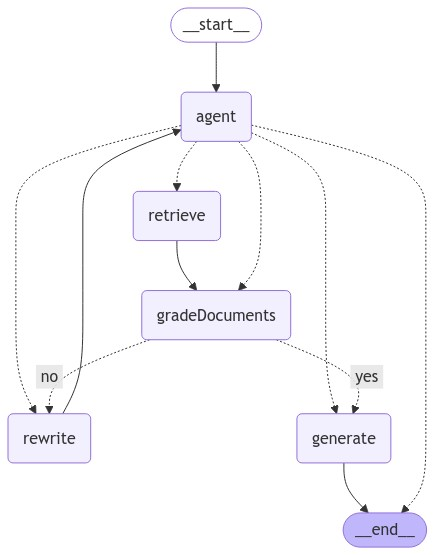

In [ ]:
import { START } from "npm:@langchain/langgraph";

// Call agent node to decide to retrieve or not
workflow.addEdge(START, "agent");

// Decide whether to retrieve
workflow.addConditionalEdges(
  "agent",
  // Assess agent decision
  shouldRetrieve,
);

workflow.addEdge("retrieve", "gradeDocuments");

// Edges taken after the `action` node is called.
workflow.addConditionalEdges(
  "gradeDocuments",
  // Assess agent decision
  checkRelevance,
  {
    // Call tool node
    yes: "generate",
    no: "rewrite", // placeholder
  },
);

workflow.addEdge("generate", END);
workflow.addEdge("rewrite", "agent");

// Compile
const app = workflow.compile();

// If running in a Jupyter notebook, display the graph visually
Deno.jupyter.image(
  await (await (await app.getGraphAsync()).drawMermaidPng()).bytes(),
);

## Asking the agent a question

Finally, we need to ask our agent a question (_"What are some new features of
Deno 2.1?"_) and see what the response is:

In [16]:
import { HumanMessage } from "npm:@langchain/core/messages";

const inputs = {
  messages: [
    new HumanMessage("What are some new features of Deno 2.1?"),
  ],
};

let finalState;
for await (const output of await app.stream(inputs)) {
  for (const [key, value] of Object.entries(output)) {
    console.log(`${key} -->`);
    finalState = value;
  }
}

const lastMessage = finalState.messages[finalState.messages.length - 1];
const content = lastMessage.content
  .replace("<think>", "<details><summary>Thinking...</summary>")
  .replace("</think>", "</details>");

Deno.jupyter.md`**Generated output from agent:**

${content}`;

---CALL AGENT---
---DECIDE TO RETRIEVE---
---DECISION: RETRIEVE---
agent -->
retrieve -->
---GET RELEVANCE---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
gradeDocuments -->
---GENERATE---
generate -->


**Generated output from agent:**

<details><summary>Thinking...</summary>
Okay, so I need to figure out what the new features of Deno 2.1 are based on the provided context. Let me start by reading through the context carefully.

The first mention is about Wasm imports being supported in Deno 2.1. That's a significant feature because it allows for better integration with WebAssembly, which can enhance performance and functionality.

Next, there's something about asset files being embedded during compilation using `deno compile`. This probably means that users can more easily include static assets like images or CSS without extra setup.

Then, stack traces in permission prompts are mentioned. I'm not entirely sure what this entails, but it likely improves debugging by providing detailed error information when permissions are denied or issues arise during runtime.

The `deno task` command is said to be turbocharged, which suggests that tasks have been optimized for better performance and efficiency, making them run faster or more smoothly.

There's also a mention of Node.js and npm compatibility improvements. This could mean that Deno now works better with existing Node.js projects, making it easier to migrate or integrate with existing setups.

The `--allow-env` wildcard feature is listed, which probably allows users to specify multiple environment files or handle environment variables more flexibly.

Formatting and linting have been improved, so developers can expect better code quality checks and suggestions within their projects.

Display images in Jupyter notebooks indicates that Deno now supports rendering images directly within Jupyter notebooks, which could be useful for data visualization and education.

Overriding versions during publication with `deno publish` gives users more control over how their packages are distributed, perhaps allowing for specific versioning strategies.

LSP improvements suggest that the language server has been enhanced, making Deno a better choice for code editing environments like VS Code.

Performance and quality of life improvements are broad categories, but they indicate that Deno 2.1 focuses on making the tool more efficient and enjoyable to use overall.

Lastly, V8 13.0 is mentioned, which likely refers to an updated version of the V8 engine, providing better performance and features for Deno's operations.

Putting this all together, Deno 2.1 introduces several key enhancements aimed at improving developer productivity, compatibility, and performance.
</details>

Deno 2.1 introduces several new features, including first-class WebAssembly (Wasm) support, embedded asset files during compilation, stack traces in permission prompts, a turbocharged `deno task` command, improved Node.js and npm compatibility, wildcard environment file support, enhanced formatting and linting, image display in Jupyter notebooks, version override options, LSP improvements, performance enhancements, and updates to the V8 engine.

## In the end

I have always though large language models would be an assistive tool, and my
experiments with a Agent RAG have highlighted to me that the concept has legs,
and amazed at what you can do locally. Using Deno and a framework like LangChain
really lets you experiment quickly as well as fine tune.

Having the ability to create an AI agent that I have complete flexibility over
open up the opportunity to make incorporating AI into solutions a distinct
possibility. I am going to continue to experiment and explore RAG systems, as
for my day job, they are the things most likely to make a difference, but there
is whole arenas of capability to explore, including data processing and
analysis, image generation and interpretation, test generation, and security.